In [54]:
import numpy as np
import pandas as pd
import seaborn

import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

digits = load_digits()

In [17]:
# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Image Data Shape" , digits.data.shape)

# Print to show there are 1797 labels (integers from 0-9)
print("Label Data Shape", digits.target.shape)


Image Data Shape (1797, 64)
Label Data Shape (1797,)


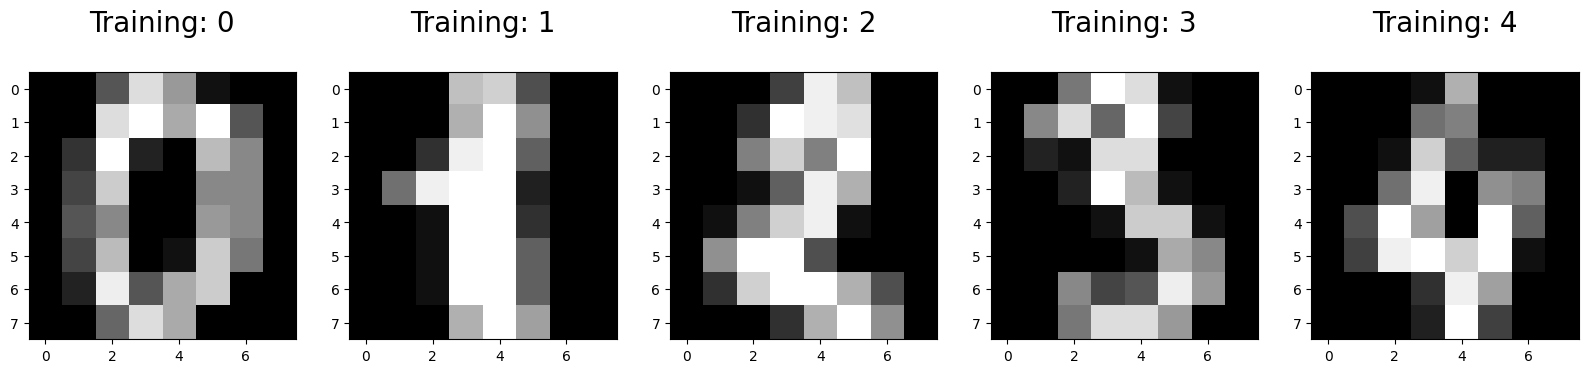

In [33]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [19]:
#split into training and test data
#X = image array (features)
#y = label array (labels)
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

In [24]:
#random forest classifier

forest = RandomForestClassifier(n_estimators=100, random_state=7) #max_depth
forest.fit(X_train, y_train)

feature_imp = pd.Series(forest.feature_importances_).sort_values(ascending=False)
feature_imp

21    0.055792
43    0.046044
42    0.039278
26    0.037837
36    0.037393
        ...   
39    0.000000
24    0.000000
16    0.000000
8     0.000000
32    0.000000
Length: 64, dtype: float64

feature importances don't really mean a lot to me in this context as we are processing images (matrices of pixels) which doesn't necessarily have distinct features that contribute to classification, as the darkness of each pixel still contributes to the image we are evaluating.
As a result, I don't think it's fair to remove any features in this situation compared to classification problems where there are a handful of obviouisly significant features, Even though you could logically argue that the pixels in the corners of the images dont contribute as much as the middle, this may obscure some images in the dataset and cause bias.


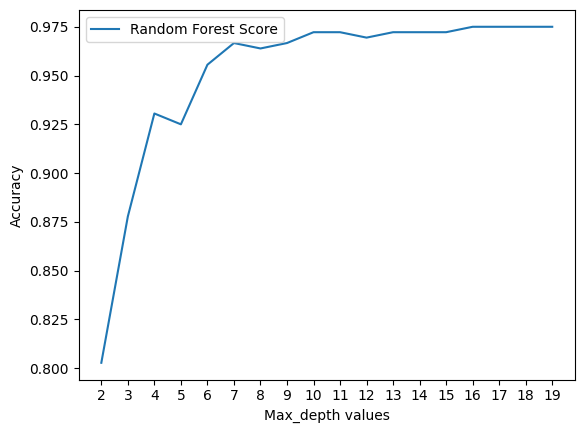

In [35]:
#tune a parameter and explain why you chose it

depths = range(2, 20)
scores_train = [] 
for d in depths:
  rfc = RandomForestClassifier(max_depth=d, random_state=15)
  rfc.fit(X_train, y_train)
  score = rfc.score(X_test, y_test)
  scores_train.append(score)

fig, ax = plt.subplots()
trainline = ax.plot(depths, scores_train, label='Random Forest Score')
plt.xlabel("Max_depth values")
plt.ylabel("Accuracy")
ax.xaxis.set_ticks(depths)
ax.legend() #makes the labels in the label params above show up on the graph
plt.show()

Max_depth tuning in this dataset is not particularly useful as the dataset is classifying numbers from 0 to 9, therefore limiting the depth of the tree may be taking away classes from the predictions which distinguish numbers from one another. For example, if I limit the depth to 5, then one of the images in the dataset which has not yet been classified in its own class at the depth of 5 will have to be classified into one of the existing classes, depending on which image it is the most similar to. As a result, the model will have a lower accuracy (more error) as numbers are forced into similar labels rather than their true labels when exposed to the rest of the data. For example, a 2 might be predicted to be a 5 because the model has not made a separate class for 2, but a different image of 2 might be classified as a 1, so there is definitely some error there.

Logically it makes sense that the depth of the tree should not be less than 9 and the accuracy remains high beyond that depth.


Instead, I choose to tune the n_estimators - the number of trees built on sub-samples before taking a vote/average for the best one, as this is likely to improve the accuracy of my model when assessing something ambiguous like images. The more the better, but I need to consider processor speed so it is reasonable to stop when the accuracy no longer increases significantly.

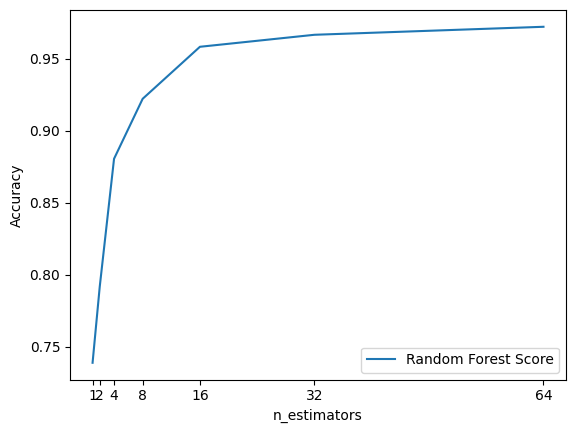

In [52]:
#tuning n_estimators
#I have changed the max_depth to be low for the purpose of tuning the n_estimators so I can clearly see a difference in the score not n_estimators

n_estimators_range = [1, 2, 4, 8, 16, 32, 64]
scores_train = [] 
for n in n_estimators_range:
  rfc = RandomForestClassifier(max_depth=10, random_state=15, n_estimators=n)
  rfc.fit(X_train, y_train)
  score = rfc.score(X_test, y_test)
  scores_train.append(score)

fig, ax = plt.subplots()
estimatorsline = ax.plot(n_estimators_range, scores_train, label='Random Forest Score')
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
ax.xaxis.set_ticks(n_estimators_range)
ax.legend() #makes the labels in the label params above show up on the graph
plt.show()

In [27]:
#select a value for said parameter to use on the data set and provide rationale for your choice

I choose to keep n_estimators limited to 32, as the accuracy does not increase significantly beyond that number so the decrease in performance is not worth the additional accuracy

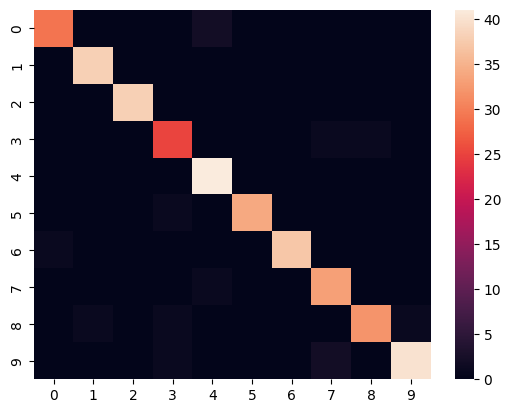

In [69]:
#print confusion matrix for random forest model on the test set

forest_test = RandomForestClassifier(n_estimators=32, random_state=7)
forest_test.fit(X_train, y_train)

y_predicted = forest_test.predict(X_test)

                          #(y actual, y predicted)
conf_mat = confusion_matrix(y_test, y_predicted)
#print(conf_mat)

seaborn.heatmap(conf_mat)
plt.show()

In [63]:
print(conf_mat)

[[29  0  0  0  2  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  1  1  0]
 [ 0  0  0  0 41  0  0  0  0  0]
 [ 0  0  0  1  0 34  0  0  0  0]
 [ 1  0  0  0  0  0 37  0  0  0]
 [ 0  0  0  0  1  0  0 33  0  0]
 [ 0  1  0  1  0  0  0  0 32  1]
 [ 0  0  0  1  0  0  0  2  0 40]]


which classes does the model struggle with the most?
It seems to struggle most with classifying the number 3, followed by 0

In [78]:
#report on the accuracy, precision, recall and f1-score.
#print(classification_report(y_test, y_train, target_names=target_names, digits=4))
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


labels = ["0", "1", "2", "3" , "4", "5", "6", "7", "8", "9"]
print(classification_report(y_test, y_predicted, target_names=labels, digits=4))

print("overall accuracy: ", accuracy_score(y_test, y_predicted))

              precision    recall  f1-score   support

           0     0.9667    0.9355    0.9508        31
           1     0.9744    1.0000    0.9870        38
           2     1.0000    1.0000    1.0000        38
           3     0.8929    0.9259    0.9091        27
           4     0.9318    1.0000    0.9647        41
           5     1.0000    0.9714    0.9855        35
           6     1.0000    0.9737    0.9867        38
           7     0.9167    0.9706    0.9429        34
           8     0.9697    0.9143    0.9412        35
           9     0.9756    0.9302    0.9524        43

    accuracy                         0.9639       360
   macro avg     0.9628    0.9622    0.9620       360
weighted avg     0.9649    0.9639    0.9639       360

overall accuracy:  0.9638888888888889


Accuracy = number of correct positive and negative predictions divided by total number of predictions.
The higher this is, the more images my model is able to correcly distinguish. As the model has a very high accuracy of 96.3%, it was able to correctly guess which number, 0-9, most of the images were representing which is really good for my model.

Precision = Number of true positives divided by true + false positives. Of all images it has classified, what proportion of them were correct. The higher this number, the more my model has correctly classified images that it has confidently classified. This is above 90% for all my classes, therefore my model performed really well here.

Recall = proportion of accurate positives out of all acurate (positive and negative) predictions. My model's ability to 'memorize' patterns and apply them to data. Again, this number was above 90% for all classes which meant the model easily recognized most images in the dataset as the correct number.

f1:
mean of the precision and recall. As the score for recall and precision were close in my model, I did not have higher precision at the cost of recall, or vice-versa. This is reflected in the very high F1 score for each class, indicating the model was accurately able to predict each label with well-balanced performance.